# Twitter Sentiment Analysis for USA Airlines on February 2015

In [641]:
#Import modules
import pandas as pd
import numpy as np
import pydot
import graphviz 
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import re

import nltk
from nltk.corpus import stopwords
# Only the first time
#nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

from nltk.tokenize import word_tokenize
#nltk.download('punkt')

#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from sklearn.model_selection import train_test_split

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

### Load the dataset

In [6]:
# using pandas to read .csv file
data = pd.read_csv("Tweets.csv")

In [7]:
tweets = data['text']

### Exploratory Analysis

In [8]:
# Have a look on the data
data.sample(100)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
5273,569222729125253121,neutral,0.6766,NaN,NaN,Southwest,NaN,KyleFogg82,NaN,0,@SouthwestAir fortunately didn't have to. The ...,NaN,2015-02-21 11:50:48 -0800,"Indianapolis, IN",Atlantic Time (Canada)
12547,570115532906569729,positive,0.6543,NaN,NaN,American,NaN,sherscott,NaN,0,@AmericanAir Thx! I hope so. IAH to DFW to OKC...,NaN,2015-02-23 22:58:29 -0800,Houston,Central Time (US & Canada)
2530,569125711556042752,negative,0.6334,Late Flight,0.3342,United,NaN,JuanJoseRG02,NaN,0,"@united: ""Left gate 5 minutes early."" \nMy tho...",NaN,2015-02-21 05:25:18 -0800,"Nashville, TN +309+ +320+",Central Time (US & Canada)
10489,569256374011428866,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,beekaytulsa,NaN,0,"@USAirways I was told a ""return call"" by a human",NaN,2015-02-21 14:04:30 -0800,Flyover country,Central Time (US & Canada)
13696,569744516715913216,negative,1.0000,Customer Service Issue,0.6953,American,NaN,Brittlyn_Lea,NaN,0,@AmericanAir this has happens so many times. I...,"[33.40901961, -111.90976239]",2015-02-22 22:24:12 -0800,NaN,Arizona
10944,568773342053969920,negative,1.0000,Late Flight,1.0000,US Airways,NaN,riricesq,NaN,0,@USAirways this is so unacceptable. I'm going ...,NaN,2015-02-20 06:05:06 -0800,On a beach,Quito
8350,568448023845572608,neutral,0.6423,NaN,NaN,Delta,NaN,smsuconn,NaN,0,@JetBlue yes he and all the princesses. Trying...,NaN,2015-02-19 08:32:24 -0800,"Alexandria, VA",Eastern Time (US & Canada)
11515,568057241435303936,negative,1.0000,Can't Tell,1.0000,US Airways,NaN,kvetcher,NaN,0,",@USAirways 2nd time this occurred in 3 weeks....",NaN,2015-02-18 06:39:35 -0800,"Major metro area, USA",Eastern Time (US & Canada)
4227,567766554600038402,neutral,0.6596,NaN,0.0000,United,NaN,CWWMUK,NaN,0,"@united No, not received any e-mails in either...",NaN,2015-02-17 11:24:29 -0800,North West of England,NaN
10805,568861899435016192,positive,1.0000,NaN,NaN,US Airways,NaN,SkyDiverChad,NaN,0,@USAirways - Check-in staff at PHX are awesome...,NaN,2015-02-20 11:57:00 -0800,"Phoenix, AZ",Arizona


In [9]:
# Data grouped by sentiment
groupedBySentiment = data.groupby(['airline_sentiment']).count()
groupedBySentiment.plot(kind='bar', figsize=(15, 8), rot=0, legend=False, title='Tweets grouped by sentiment', y='tweet_id');

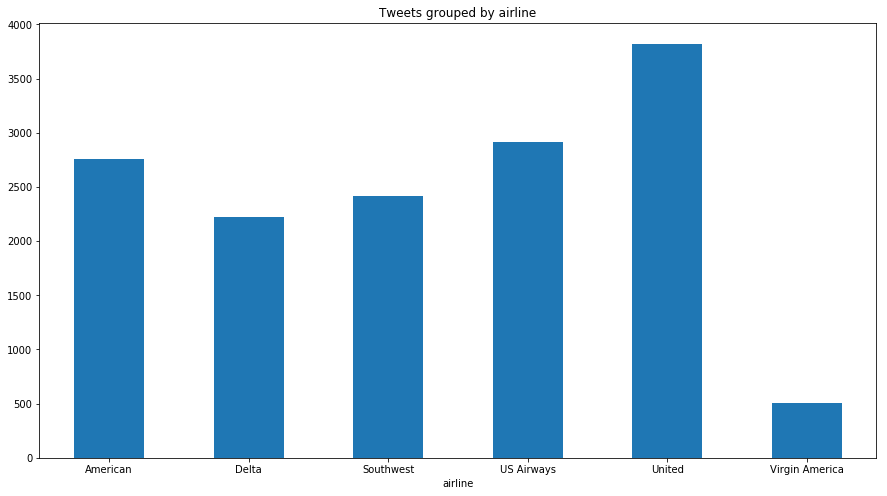

In [10]:
# Data grouped by airline
groupedByAirline = data.groupby(['airline']).count()
groupedByAirline.plot(kind='bar', figsize=(15, 8), rot=0, legend=False, title='Tweets grouped by airline', y='tweet_id');

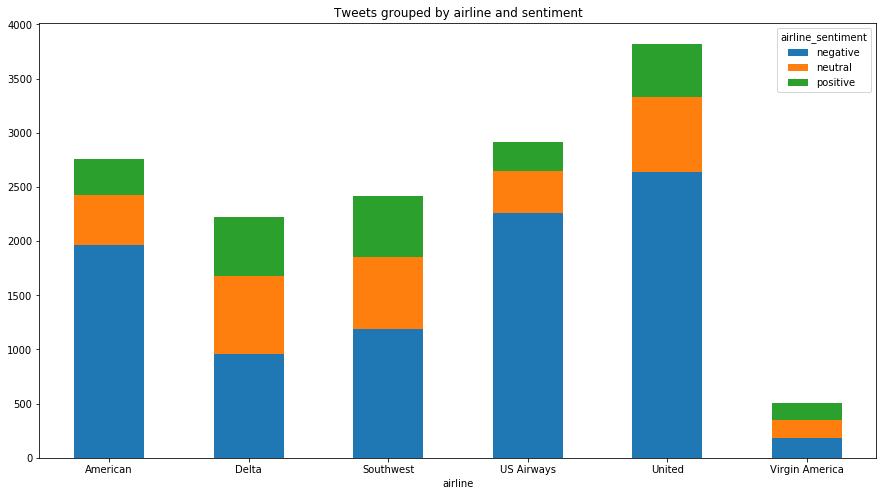

In [11]:
groupedByAirline = data.groupby(['airline', 'airline_sentiment']).count().unstack()
groupedByAirline.plot(kind='bar', figsize=(15, 8), rot=0, stacked=True,  title='Tweets grouped by airline and sentiment', y='tweet_id');

In [12]:
reasonPerTweet = data[['airline','negativereason']]
groupedByReasonPerTweet = reasonPerTweet.groupby('negativereason', as_index=False).count()
groupedByReasonPerTweet.sort_values('airline', ascending=False)

,negativereason,airline
3,Customer Service Issue,2910
7,Late Flight,1665
1,Can't Tell,1190
2,Cancelled Flight,847
8,Lost Luggage,724
0,Bad Flight,580
6,Flight Booking Problems,529
5,Flight Attendant Complaints,481
9,longlines,178
4,Damaged Luggage,74


### Preprocessing the data

In [649]:
def preprocess(tweet):
    # Remove "@user" from tweets
    tweet = re.sub('@[\w]*',"",tweet)
    
    # Remove the URLs
    tweet  = re.sub('((www\.[\S]+)|(https?://[\S]+))',"",tweet)
    
    # Remove points, hashtags, commas and all kind of symbols as well as numbers - Letters Only
    tweet = re.sub('[^a-zA-Z\s]'," ", tweet)
    tweet = re.sub('\s[a-zA-z]\s'," ", tweet)
    
    # Convert all to lowercase
    tweet = tweet.lower()
        
    # Tokenize
    tweet = word_tokenize(tweet)
    
    # Filter out stop words
    tweet = list(filter(lambda l: l not in stop_words, tweet))
    
    tweet = [wordnet_lemmatizer.lemmatize(word) for word in tweet]

    return tweet

tweets = tweets.apply(preprocess)

### Tokenizing, encoding and creating sequences of equal length from available tweets

In [650]:
NUM_WORDS = 3000        # the top most n frequent words to consider

tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ')
tokenizer.fit_on_texts(tweets)

# Prints the internal dictionary containing all the words after fit_on_texts was called
# print(tokenizer.word_index)
# Converts the tweets from sequences of words to sequences of integers where each integer is the index of the word in word_index dictionary
X = tokenizer.texts_to_sequences(tweets)

# Adds some padding whenever is needed so that all sequences have the same lenght
X = pad_sequences(X)

print(X)

[[   0    0    0 ...    0    0  122]
 [   0    0    0 ...  928 1062  104]
 [   0    0    0 ...   62   70   96]
 ...
 [   0    0    0 ...  491  323   23]
 [   0    0    0 ...  887   42 2031]
 [   0    0    0 ...   66   93    1]]


### Split the dataset to train and test

In [651]:
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 111)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=1)
print('Train dataset', X_train.shape,Y_train.shape)
print('Validation dataset', X_val.shape, Y_val.shape)
print('Test dataset', X_test.shape,Y_test.shape)

Train dataset (9882, 21) (9882, 3)
Validation dataset (1098, 21) (1098, 3)
Test dataset (3660, 21) (3660, 3)


### Create the model

In [652]:
model = Sequential()
# An embedding layer with a vocabulary of 3000, a vector space of 96 dimensions in which words will be embedded and input documents with 32 words each
model.add(Embedding(NUM_WORDS, 96, input_length = X.shape[1] )) 
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='sigmoid'))
print(model.summary()) 

#plot_model(model,to_file='model_plot.png',show_shapes=True,show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 21, 96)            288000    
_________________________________________________________________
lstm_36 (LSTM)               (None, 96)                74112     
_________________________________________________________________
dense_36 (Dense)             (None, 3)                 291       
Total params: 362,403
Trainable params: 362,403
Non-trainable params: 0
_________________________________________________________________
None


In [607]:
# Function to choose the best optimizer
def compileAndFitModel(model, opt):
    model.save_weights('model.h5')
    model.compile(loss='categorical_crossentropy',  
                  optimizer=opt,        
                  metrics=['accuracy'])
                  # Train
    BATCH_SIZE = 24
    EPOCHS = 5
    cbk_early_stopping = EarlyStopping(monitor='val_acc', patience=2, mode='max')
    print()
    print('-------------------------- Optimizer: ', opt ,'--------------------------')
    print()
    model.fit(X_train, Y_train, BATCH_SIZE, epochs=EPOCHS, 
                validation_data=(X_val, Y_val), 
                callbacks=[cbk_early_stopping] )
    model.load_weights('model.h5')

In [608]:
optimizers = ['SGD', 'Adam', 'Adagrad','Adadelta', 'RMSprop','Adamax', 'Nadam']
for opt in optimizers:
    compileAndFitModel(model, opt)
    


-------------------------- Optimizer:  SGD --------------------------

Train on 9882 samples, validate on 1098 samples
Epoch 1/5
9882/9882 [==============================] - 33s 3ms/step - loss: 0.9945 - acc: 0.6212 - val_loss: 0.9311 - val_acc: 0.6302
Epoch 2/5
9882/9882 [==============================] - 28s 3ms/step - loss: 0.9218 - acc: 0.6247 - val_loss: 0.9132 - val_acc: 0.6302s - loss: 0.9221 - acc: - ETA: 0s - loss: 0.9214 - acc: 0.625
Epoch 3/5
9882/9882 [==============================] - 34s 3ms/step - loss: 0.9151 - acc: 0.6247 - val_loss: 0.9096 - val_acc: 0.6302

-------------------------- Optimizer:  Adam --------------------------

Train on 9882 samples, validate on 1098 samples
Epoch 1/5
9882/9882 [==============================] - 49s 5ms/step - loss: 0.7155 - acc: 0.7028 - val_loss: 0.5578 - val_acc: 0.7769
Epoch 2/5
9882/9882 [==============================] - 29s 3ms/step - loss: 0.4740 - acc: 0.8116 - val_loss: 0.5442 - val_acc: 0.7951
Epoch 3/5
9882/9882 [=======

In [653]:
model.compile(loss='categorical_crossentropy',  
                  optimizer='Adagrad',        
                  metrics=['accuracy'])

In [654]:
# Train
BATCH_SIZE = 24
EPOCHS = 10
cbk_early_stopping = EarlyStopping(monitor='val_acc', patience=2, mode='max')
history = model.fit(X_train, Y_train, BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(X_val, Y_val), 
            callbacks=[cbk_early_stopping] )


Train on 9882 samples, validate on 1098 samples
Epoch 1/10
9882/9882 [==============================] - 36s 4ms/step - loss: 0.6728 - acc: 0.7249 - val_loss: 0.5638 - val_acc: 0.7805
Epoch 2/10
9882/9882 [==============================] - 23s 2ms/step - loss: 0.4845 - acc: 0.8085 - val_loss: 0.5280 - val_acc: 0.7914
Epoch 3/10
9882/9882 [==============================] - 24s 2ms/step - loss: 0.4199 - acc: 0.8357 - val_loss: 0.5298 - val_acc: 0.7951
Epoch 4/10
9882/9882 [==============================] - 23s 2ms/step - loss: 0.3752 - acc: 0.8585 - val_loss: 0.5455 - val_acc: 0.7951
Epoch 5/10
9882/9882 [==============================] - 23s 2ms/step - loss: 0.3448 - acc: 0.8704 - val_loss: 0.5646 - val_acc: 0.7987
Epoch 6/10
9882/9882 [==============================] - 23s 2ms/step - loss: 0.3211 - acc: 0.8798 - val_loss: 0.5907 - val_acc: 0.7960
Epoch 7/10
9882/9882 [==============================] - 23s 2ms/step - loss: 0.3015 - acc: 0.8889 - val_loss: 0.6086 - val_acc: 0.7951


In [656]:
def plot_keras_history(history):

    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

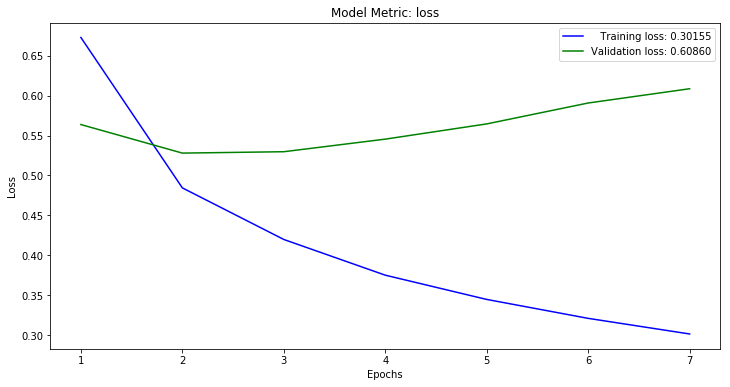

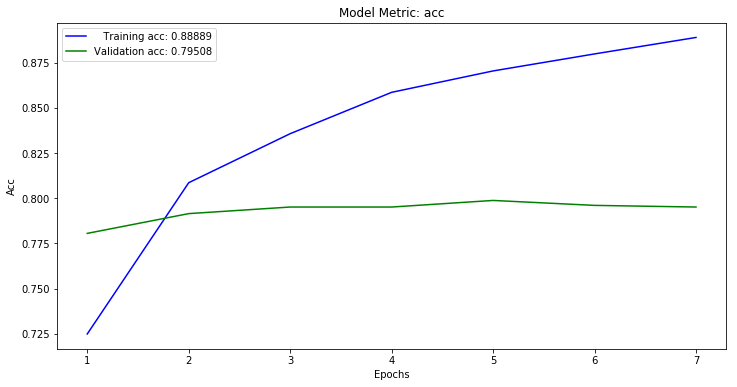

In [657]:
plot_keras_history(history)

### Model Evaluation

In [659]:
score = model.evaluate(
    X_test,  # features
    Y_test,  # labels
    batch_size=24,  # batch size
    verbose=1  # the mostX_test extended verbose
)

print('\nTest categorical_crossentropy:', score[0])
print('\nTest accuracy:', score[1])

3660/3660 [==============================] - 2s 488us/step

Test categorical_crossentropy: 0.622052510693425

Test accuracy: 0.7756830584807474


## Data Pre- Processing for CNN Model

As we can see the tweets includes some textual aspects. There are images, links, emoticons, and other forms of media. Hence, the first thing is to clean the tweets using the apply() function with lambda

- Search for pattern matches or performing string subtitutions -- re
- Delete the pattern i -- sub-- and replace it with " "

In [13]:
import string, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

import re

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D
from keras.layers import GlobalMaxPooling1D, concatenate
from keras.optimizers import Adam
from keras.utils import np_utils

Using TensorFlow backend.


In [14]:
# Remove "@user" from tweets
tweets = tweets.apply((lambda x: re.sub('@[\w]*',"",str(x))))  # delete the pattern i ("@user") and replace it with " "

# Remove URL
tweets = tweets.apply((lambda x: re.sub('((www\.[\S]+)|(https?://[\S]+))',"",str(x))))

# Remove points, hashtags, commas and all kind of symbols as well as numbers - Letters Only
tweets = tweets.apply((lambda x: re.sub('[^a-zA-Z]'," ",x)))

In [15]:
tweets.head()

0                                          What  said 
1     plus you ve added commercials to the experien...
2     I didn t today    Must mean I need to take an...
3     it s really aggressive to blast obnoxious  en...
4             and it s a really big bad thing about it
Name: text, dtype: object

Now, convert more than 2 letters repetitions to 2 letters

In [16]:
# e.g noooooope --> noope
def remove_rep(my_repletter):
    #for letter in my_repletter:
    my_repletter = re.sub(r'(.)\1+', r'\1\1', str(my_repletter))
        
    return my_repletter

# Update the new_text column with the new values
tweets = np.vectorize(remove_rep)(tweets)
tweets

array([' What  said ',
       ' plus you ve added commercials to the experience  tacky ',
       ' I didn t today  Must mean I need to take another trip ', ...,
       ' Please bring American Airlines to  BlackBerry  ',
       ' you have my money  you change my flight  and don t answer your phones  Any other suggestions so I can make my commitment  ',
       ' we have  ppl so we need  know how many seats are on the next flight  Plz put us on standby for  people on the next flight '],
      dtype='<U173')

### Tokenizing, encoding and creating sequences of equal length from available tweets

In [17]:
#Encode categorical label class into numerical

le = LabelEncoder()
data['classes'] = le.fit_transform(data['airline_sentiment'])

#data.head()

In [18]:
# Tweets length 

length = []
for x in tweets:
    length.append(len(x.split()))
max(length)

33

In [19]:
maxlen=40    #  maximum length of tokens to use for each tweet 
NUM_WORDS = 6000 # We limit the dictionary- vocabulary size to the top 6000 most frequent tokens

In [20]:
#Tokenization
tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ')
tokenizer.fit_on_texts(tweets)

# Prints the internal dictionary containing all the words after fit_on_texts was called
#print(tokenizer.word_index)

# Converts the tweets from sequences of words to sequences of integers where each integer is the index of the word in word_index dictionary
T = tokenizer.texts_to_sequences(tweets)

# Adds some padding whenever is needed so that all sequences have the same lenght
X = pad_sequences(T, maxlen=40)
X

array([[   0,    0,    0, ...,    0,   44,  215],
       [   0,    0,    0, ...,    3,  192, 5735],
       [   0,    0,    0, ...,  146,  140,  184],
       ...,
       [   0,    0,    0, ...,  438,  245,    1],
       [   0,    0,    0, ...,  119,   10, 2511],
       [   0,    0,    0, ...,    3,  172,    7]])

### Split the dataset to train and test

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X,data['classes'], test_size = 0.2, random_state = 111)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11712, 40) (11712,)
(2928, 40) (2928,)


In [22]:
X.shape[1]

40

### Set Hyper-parameters

In [26]:
# Convert array of labeled data (0,1,2) to one-hot vector using "np_utils"
encoded_Y = np_utils.to_categorical(Y_train) 
encoded_Y_test = np_utils.to_categorical(Y_test)

In [48]:
import string, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import re

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D
from keras.layers import GlobalMaxPooling1D, concatenate
from keras.optimizers import Adam
from keras.utils import np_utils

def cnn_model():
    model = Sequential([Embedding(input_dim = NUM_WORDS, output_dim = 32, input_length = maxlen), 
                        Convolution1D(64, 2, padding='same', activation='relu'),
                        MaxPooling1D(),
                        Flatten(),
                        Dense(25, activation='relu'),
                        Dropout(0.2),
                        Dense(3, activation='softmax')])
             # Compiling the Model
        
# using categorical crossentropy as a loss function 
# and Adam as an optimizer (is more robust thatn Gradient Descent Optimizer)
# As a metric we can use "accuracy"

    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [49]:
model = cnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 40, 32)            192000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 40, 64)            4160      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 25)                32025     
_________________________________________________________________
dropout_8 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 78        
Total para

### Fit - Train the CNN Model

In [50]:
model = cnn_model()

# For our validation data, we will use the test set provided to us in our dataset, which we have split into X_test and encoded_Y_test.

history = model.fit(X_train, encoded_Y, validation_data=(X_test, encoded_Y_test), epochs=5, batch_size=100) 

Train on 11712 samples, validate on 2928 samples
Epoch 1/5
11712/11712 [==============================] - 1s 127us/step - loss: 0.8405 - acc: 0.6370 - val_loss: 0.6986 - val_acc: 0.6851
Epoch 2/5
11712/11712 [==============================] - 1s 88us/step - loss: 0.5950 - acc: 0.7579 - val_loss: 0.5268 - val_acc: 0.7999
Epoch 3/5
11712/11712 [==============================] - 1s 91us/step - loss: 0.4086 - acc: 0.8500 - val_loss: 0.5198 - val_acc: 0.7951
Epoch 4/5
11712/11712 [==============================] - 1s 91us/step - loss: 0.3109 - acc: 0.8878 - val_loss: 0.5347 - val_acc: 0.7930
Epoch 5/5
11712/11712 [==============================] - 1s 90us/step - loss: 0.2464 - acc: 0.9139 - val_loss: 0.5938 - val_acc: 0.7900


In [51]:
def plot_keras_history(history):

    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

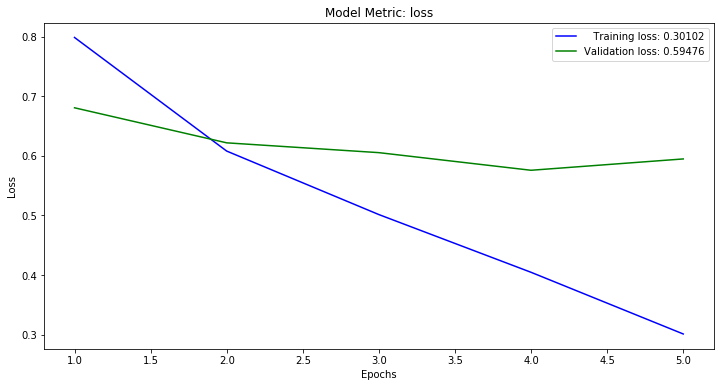

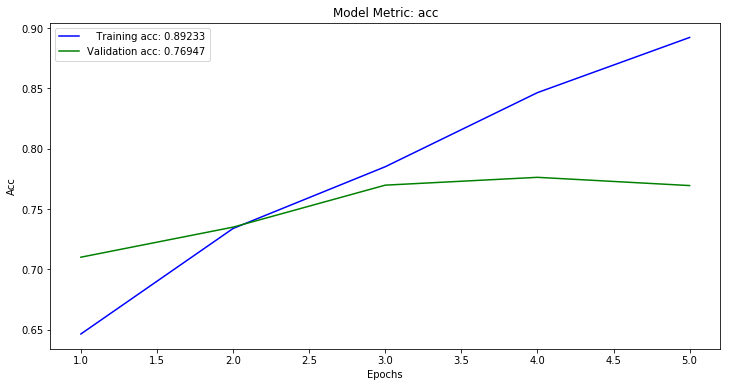

In [30]:
plot_keras_history(history)

### Make predictions

In [52]:
preds = model.predict(X_test)

### Model Evaluation

In [53]:
metrics.accuracy_score(Y_test, np.argmax(preds, axis=1))

0.7899590163934426

In [54]:
print(metrics.classification_report(Y_test, np.argmax(preds, axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1844
           1       0.64      0.57      0.61       637
           2       0.72      0.70      0.71       447

   micro avg       0.79      0.79      0.79      2928
   macro avg       0.74      0.72      0.73      2928
weighted avg       0.78      0.79      0.79      2928



##### Try to improve CNN performance changing the number of filters and their dimension 

In [44]:
def cnn_model():
    model2 = Sequential([Embedding(input_dim = NUM_WORDS, output_dim = 32, input_length = maxlen),
                        Convolution1D(128, 3, padding='same', activation='relu'),  
                        MaxPooling1D(),
                        Flatten(),
                        Dense(25, activation='relu'),
                        Dropout(0.2),
                        Dense(3, activation='softmax')])
# compiling the model
# using categorical crossentropy as a loss function 
# and Adam as an optimizer (is more robust thatn Gradient Descent Optimizer)
# As a metric we can use "accuracy"
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [45]:
model2 = cnn_model()
model2.fit(X_train, encoded_Y, validation_data=(X_test, encoded_Y_test), epochs=4, batch_size=100)

Train on 11712 samples, validate on 2928 samples
Epoch 1/4
11712/11712 [==============================] - 3s 251us/step - loss: 0.1304 - acc: 0.9583 - val_loss: 0.7629 - val_acc: 0.7760
Epoch 2/4
11712/11712 [==============================] - 2s 212us/step - loss: 0.0833 - acc: 0.9753 - val_loss: 0.8889 - val_acc: 0.7664
Epoch 3/4
11712/11712 [==============================] - 2s 200us/step - loss: 0.0605 - acc: 0.9844 - val_loss: 0.9886 - val_acc: 0.7749
Epoch 4/4
11712/11712 [==============================] - 2s 201us/step - loss: 0.0458 - acc: 0.9871 - val_loss: 1.0575 - val_acc: 0.7661


###### As we can see the accuracy in validation dataset did not improve

In [46]:
preds2 = model2.predict(X_test)

In [47]:
metrics.accuracy_score(Y_test, np.argmax(preds2, axis=1))

0.766051912568306